In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl

import scipy.stats
import pylab

import statsmodels.graphics.tsaplots as sgt
import statsmodels.tsa.stattools as sts
from statsmodels.tsa.seasonal import seasonal_decompose

from pmdarima import auto_arima
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tools.eval_measures import rmse
from sklearn.metrics import mean_squared_error, mean_absolute_error

import warnings
warnings.filterwarnings("ignore")

# Import CSV Data into Pandas DataFrame

In [3]:
df = pd.read_csv('data/data-for-test2.csv')
df.head(3)

,datetime,irradiance,humidity,temperature,energy
0,1/1/16 0:00,0.000,72.7,21.556,0.0
1,1/1/16 0:05,0.000,73.0,21.556,0.0
2,1/1/16 0:10,0.396,73.3,21.500,0.0


In [4]:
df.shape

(200000, 5)

### Note: `non-null` = 200,000 for all columns

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200000 entries, 0 to 199999
Data columns (total 5 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   datetime     200000 non-null  object 
 1   irradiance   200000 non-null  float64
 2   humidity     200000 non-null  float64
 3   temperature  200000 non-null  float64
 4   energy       200000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 7.6+ MB


### Convert `dtype` of `df['datetime']` to `Datetime`
- Note that date range is 
```
first     2016-01-01 00:00:00
last      2018-01-07 17:35:00
```

In [6]:
df['datetime'] = pd.to_datetime(df['datetime'], format="%m/%d/%y %H:%M")
df.head(3)

,datetime,irradiance,humidity,temperature,energy
0,2016-01-01 00:00:00,0.000,72.7,21.556,0.0
1,2016-01-01 00:05:00,0.000,73.0,21.556,0.0
2,2016-01-01 00:10:00,0.396,73.3,21.500,0.0


In [7]:
df.dtypes

datetime       datetime64[ns]
irradiance            float64
humidity              float64
temperature           float64
energy                float64
dtype: object

In [8]:
df['datetime'].describe()

count                  200000
unique                 200000
top       2016-03-22 14:15:00
freq                        1
first     2016-01-01 00:00:00
last      2018-01-07 17:35:00
Name: datetime, dtype: object

# Make the `datetime` Column the Index

In [9]:
df.set_index('datetime', inplace=True)
df

,irradiance,humidity,temperature,energy
datetime,,,,
2016-01-01 00:00:00,0.000,72.7,21.556,0.00
2016-01-01 00:05:00,0.000,73.0,21.556,0.00
2016-01-01 00:10:00,0.396,73.3,21.500,0.00
2016-01-01 00:15:00,0.791,73.3,21.389,0.00
2016-01-01 00:20:00,0.396,73.3,21.278,0.00
...,...,...,...,...
2018-01-07 17:15:00,193.286,58.1,25.556,7.73
2018-01-07 17:20:00,557.061,57.1,25.889,8.01
2018-01-07 17:25:00,528.811,58.2,25.667,10.39


# Observation: Data Frequency = 5 mins 


# Observation: Missing Data
- For example, missing data at `2016-01-01 02:10:00` as shown below

In [10]:
df.loc['2016-01-01 02:05':'2016-01-01 02:15']

,irradiance,humidity,temperature,energy
datetime,,,,
2016-01-01 02:05:00,0.396,75.8,20.056,0.0
2016-01-01 02:15:00,0.791,76.0,20.056,0.0


# Set the Desired Frequency to 5 Mins (300 Seconds)

In [11]:
df = df.asfreq('300S')
df.head()

,irradiance,humidity,temperature,energy
datetime,,,,
2016-01-01 00:00:00,0.000,72.7,21.556,0.0
2016-01-01 00:05:00,0.000,73.0,21.556,0.0
2016-01-01 00:10:00,0.396,73.3,21.500,0.0
2016-01-01 00:15:00,0.791,73.3,21.389,0.0
2016-01-01 00:20:00,0.396,73.3,21.278,0.0


### Now, have `NaN` at `2016-01-01 02:10:00`

In [12]:
df.loc['2016-01-01 02:05':'2016-01-01 02:15']

,irradiance,humidity,temperature,energy
datetime,,,,
2016-01-01 02:05:00,0.396,75.8,20.056,0.0
2016-01-01 02:10:00,NaN,NaN,NaN,NaN
2016-01-01 02:15:00,0.791,76.0,20.056,0.0


# Handling Missing Values
- There are 12468 missing values as shown below
- We use `fillna()` method to fill the missing values
- We use front filling (as opposed to back filling) because we notice an outlier right after the data gap
  - For example, the outliers 3390 at `2016-04-28 11:50`, which follows the data gap between `2016-04-25 10:40` and `2016-04-28 11:45`
  - If we use back filling, we will end up filling the missing values with outliers
- Note: We may also fill the value with the average value (mean) if the data is fluctuated around the mean from the first to last data.  In general, if might not be a good approach for time series because of the underlying time variant data of time series 

In [13]:
df.isnull().sum()

irradiance     12468
humidity       12468
temperature    12468
energy         12468
dtype: int64

In [14]:
with pd.option_context('display.max_rows', None):
    display(df.loc['2016-04-25 10:20':'2016-04-28 12:10'])

,irradiance,humidity,temperature,energy
datetime,,,,
2016-04-25 10:20:00,215.947,66.0,24.778,3.0
2016-04-25 10:25:00,236.909,64.7,25.167,0.0
2016-04-25 10:30:00,252.729,63.3,25.500,0.0
2016-04-25 10:35:00,136.055,63.1,25.389,0.0
2016-04-25 10:40:00,NaN,NaN,NaN,NaN
2016-04-25 10:45:00,NaN,NaN,NaN,NaN
2016-04-25 10:50:00,NaN,NaN,NaN,NaN
2016-04-25 10:55:00,NaN,NaN,NaN,NaN
2016-04-25 11:00:00,NaN,NaN,NaN,NaN


# Fill Missing Values with Front Filling
- Use `df.isnull().sum()` to verify that there is no missing values
- A spot check shows that we now have the data at 2016-01-01 02:10:00

In [15]:
df['irradiance']  = df['irradiance'].fillna(method="ffill")
df['humidity']    = df['humidity'].fillna(method="ffill")
df['temperature'] = df['temperature'].fillna(method="ffill")
df['energy']      = df['energy'].fillna(method="ffill")

In [16]:
df.isnull().sum()

irradiance     0
humidity       0
temperature    0
energy         0
dtype: int64

In [17]:
df.loc['2016-01-01 02:05':'2016-01-01 02:15']

,irradiance,humidity,temperature,energy
datetime,,,,
2016-01-01 02:05:00,0.396,75.8,20.056,0.0
2016-01-01 02:10:00,0.396,75.8,20.056,0.0
2016-01-01 02:15:00,0.791,76.0,20.056,0.0


# Outliers - A Plot Shows Outliers of irradiance

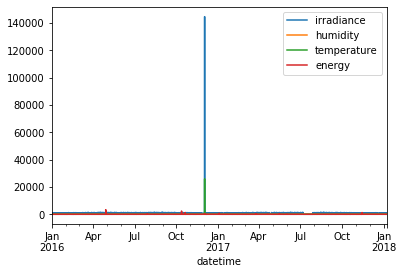

In [18]:
df.plot();

# 99 percentile and 1 percentile of irradiance
- 99 percentile of irradiance is 1117.09
- 1 percentile of irradiance is 0


- We use **Capping and Flooring** to impute all outliers above 3\*99-percentile and will impute the outliers to 3\*99-percentile
- Since 1-percentile is 0 and the minimum value of irradiance is 0, we will **not** impute the value of 0

**Notes**
- Using 3 as multiplier is a rule of thumb for starter
- We can use other multiplier instead of 3 after further analyzing the data
- Other methods to impute the outliers are 
  - **Exponential Smoothing** - Extrapolate curve between 95-percentile and 99-percential and cap all the values falling outside to the value generated by the curve
  - **Sigma Approach** where outliers are the values falling outside $\mu \pm x\sigma$

In [18]:
np.percentile(df['irradiance'],[99])

array([1117.09])

In [19]:
np.percentile(df['irradiance'],[1])

array([0.])

### Locate Outliers of irradiance

In [20]:
df[df['irradiance'] > 3*np.percentile(df['irradiance'],[99])[0]]

,irradiance,humidity,temperature,energy
datetime,,,,
2016-12-02 10:15:00,144552.0,8.636,25948.8,1.0
2016-12-02 10:20:00,144552.0,6.035,25917.3,3.0


# Impute the Outlier

In [21]:
cap_value = 3*np.percentile(df['irradiance'],[99])[0]
cap_value

3351.2699999999995

In [22]:
df.loc[df['irradiance'] > cap_value, 'irradiance'] = cap_value

### Verify that the values

In [23]:
df.loc['2016-12-02 10:15':'2016-12-02 10:20']

,irradiance,humidity,temperature,energy
datetime,,,,
2016-12-02 10:15:00,3351.27,8.636,25948.8,1.0
2016-12-02 10:20:00,3351.27,6.035,25917.3,3.0


# Outliers - A Plot Shows Outliers of temperature
- Use the same method to impute the value

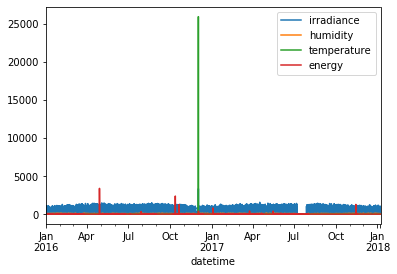

In [24]:
df.plot();

In [25]:
np.percentile(df['temperature'],[99])

array([31.])

In [26]:
np.percentile(df['temperature'],[1])

array([0.])

In [27]:
cap_value = 3*np.percentile(df['temperature'],[99])[0]
cap_value

93.0

In [28]:
df.loc[df['temperature'] > cap_value, 'temperature'] = cap_value

# Outliers - A Plot Shows Outliers of energy
- Use the same method to impute the value

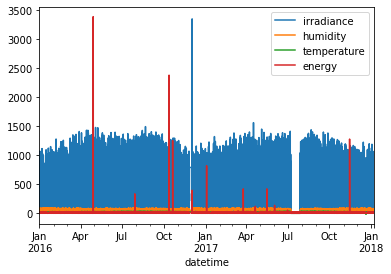

In [72]:
df.plot();

In [29]:
np.percentile(df['energy'],[99])

array([21.])

In [30]:
np.percentile(df['energy'],[1])

array([0.])

In [31]:
cap_value = 3*np.percentile(df['energy'],[99])[0]
cap_value

63.0

In [32]:
df.loc[df['energy'] > cap_value, 'energy'] = cap_value

# Another Plot to Verify No Outliers
- The plot shows the large spikes of irradiance, which is the 3\*99-percentile that we imputed earlier
- We keep this in mind and **may revisit** it after further analysis

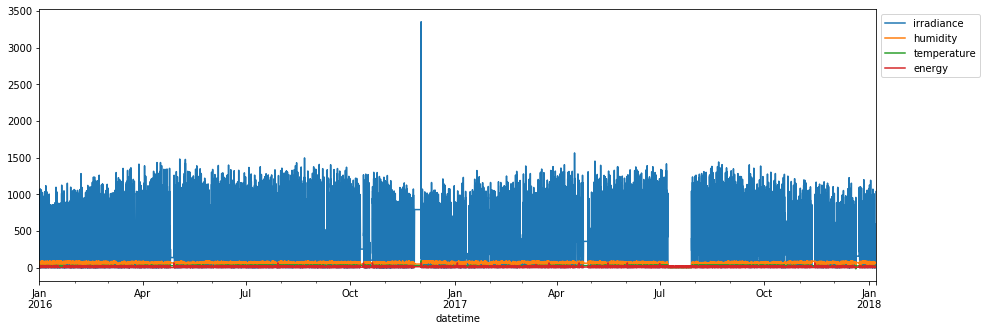

In [33]:
df.plot(figsize=(15,5)).legend(bbox_to_anchor=(1.0, 1), loc='upper left');

# Observation - Data Gap 1 of 2
- In the last plot, we notice data gaps in few intervals
- Those gaps have the value from our front filling of missing values 
  - See the first plot below
- This looks okay

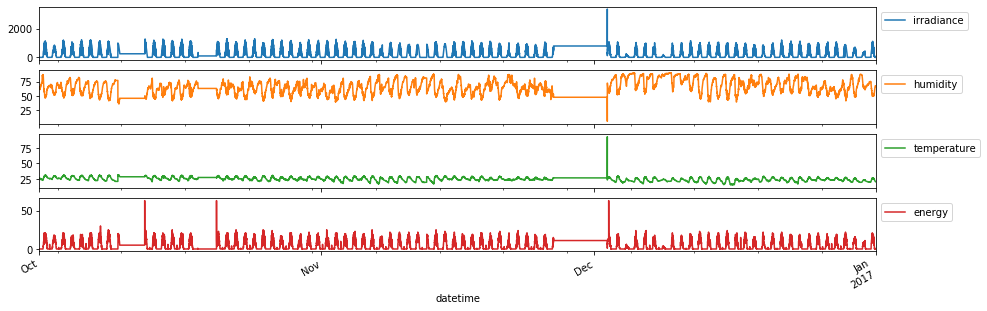

In [34]:
df.loc['2016-10-01 00:00':'2017-01-01 00:00'].plot(subplots=True, layout=(4,1), figsize=(15,5));
[ax.legend(bbox_to_anchor=(1.0, 1), loc='upper left') for ax in plt.gcf().axes];

# Observation - Data Gap 2 of 2
- However, this second plot shows the missing data of irradiance, humidity, and temperature (not the energy)
- Their 0 values seem to be data error (i.e., **not** because we adjust the data frequency and foreward fill)
- The data is between `2017-07-07 20:50` and `2017-07-28 17:25` (**6008 rows** or approx. **3%** of the data)
- We will impute them with the global mean
- **Note:** Other alternatives are segment-based mean/median or LOCF (Last Observation Carried Forward)

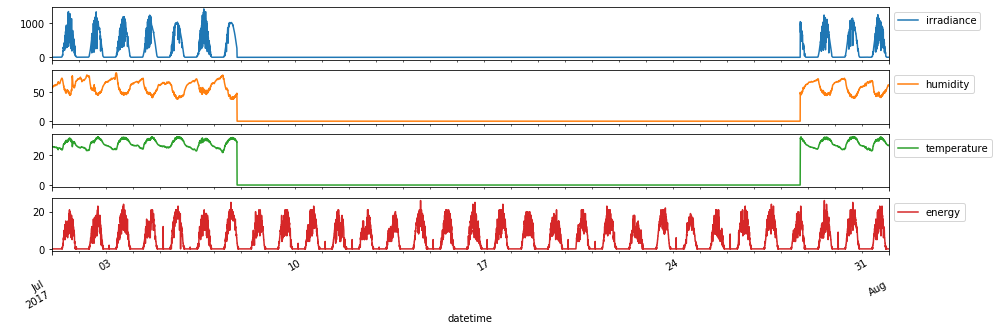

In [35]:
df.loc['2017-07-01 00:00':'2017-08-01 00:00'].plot(subplots=True, layout=(4,1), figsize=(15,5));
[ax.legend(bbox_to_anchor=(1.0, 1), loc='upper left') for ax in plt.gcf().axes];

In [36]:
df.loc['2017-07-07 20:50':'2017-07-28 17:25'].agg(['count','sum'])

,irradiance,humidity,temperature,energy
count,6008.0,6008.0,6008.0,6008.0
sum,0.0,0.0,0.0,30007.0


In [37]:
df.loc['2017-07-07 20:50':'2017-07-28 17:25', 'irradiance'] = df['irradiance'].mean()
df.loc['2017-07-07 20:50':'2017-07-28 17:25', 'humidity'] = df['humidity'].mean()
df.loc['2017-07-07 20:50':'2017-07-28 17:25', 'temperature'] = df['temperature'].mean()

# Plot to Verify the Data

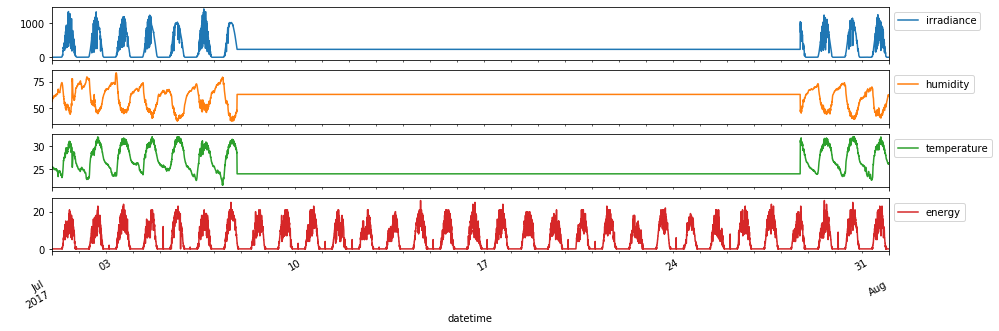

In [38]:
df.loc['2017-07-01 00:00':'2017-08-01 00:00'].plot(subplots=True, layout=(4,1), figsize=(15,5));
[ax.legend(bbox_to_anchor=(1.0, 1), loc='upper left') for ax in plt.gcf().axes];

In [39]:
df.loc['2017-07-07 20:50':'2017-07-28 17:25'].agg(['count','sum'])

,irradiance,humidity,temperature,energy
count,6.008000e+03,6008.000000,6008.000000,6008.0
sum,1.400981e+06,379272.935408,144122.733728,30007.0


# Stationarity Definition
- Constant mean
- Constant variance
- Consistent covariance between periods at identical distance from one another, e.g., Cov(x1,x4) = Cov(x3,x6)

# Dickey-Fuller Test (DF Test)

```
H0: Non-Stationary
H1: Stationary

If test statistics < critical value, reject H0 (i.e. stationarity)
```
**irradiance**
- Test statistics = -54.62
- The 1%, 5%, and 10% critical values from Dickey-Fuller test are displayed
- Since -54.62 is less than those values, **according to DF Test**, irradiance is stationary for all significance levels


- p-value = 0.0
- 0% chance of not rejecting the null, i.e. stationarity **according to DF Test**

**humidity, temperature, and energy**
- Similary results as irradiance

# Non-Statinary
- A stationary time series is one whose properties do not depend on the time at which the series is observed
- In spite of DF Test, we saw the plots above (as well as the seasonality analysis in the next section) that these time series exhibit seasonality
- The seasonality will affect the value of the time series at different times, and hence these time series **are non-stationary**

In [40]:
sts.adfuller(df['irradiance'])

(-54.62495184840665,
 0.0,
 73,
 212394,
 {'1%': -3.4303807889066267,
  '5%': -2.861553608293716,
  '10%': -2.5667772432047298},
 2640699.5023161294)

In [93]:
sts.adfuller(df['humidity'])

(-44.58489805554521,
 0.0,
 82,
 212385,
 {'1%': -3.4303807902113492,
  '5%': -2.8615536088703837,
  '10%': -2.5667772435116696},
 580270.539349754)

In [94]:
sts.adfuller(df['temperature'])

(-41.430444822971175,
 0.0,
 64,
 212403,
 {'1%': -3.4303807876020147,
  '5%': -2.8615536077170978,
  '10%': -2.566777242897816},
 110038.41059403063)

In [95]:
sts.adfuller(df['energy'])

(-55.059097062609546,
 0.0,
 82,
 212385,
 {'1%': -3.4303807902113492,
  '5%': -2.8615536088703837,
  '10%': -2.5667772435116696},
 864383.9582008406)

# Seasonality and Trend
- We notice peaks and valleys when plotting irradiance below
- This happens every 24 hours
- Since the frequency of the data is 5 mins, set period = (60/5)\*24 = 288 
- The analysis of irradiance, humidity, temperature, and energy displays **seasonality**
- In the plots, we **do not observe trend** in irradiance, humidity, temperature, and energy

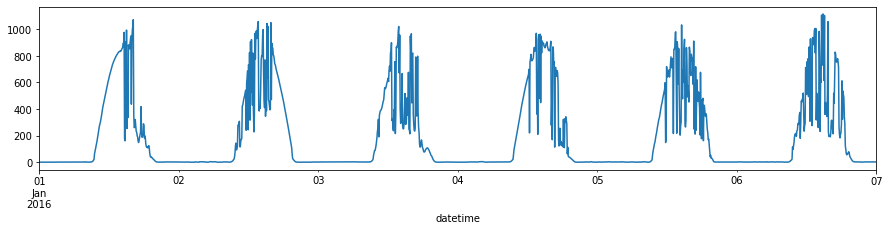

In [53]:
df.loc['2016-01-01 00:00':'2016-01-07 00:00', 'irradiance'].plot(figsize=(15,3));

### irradiance - Seasonality

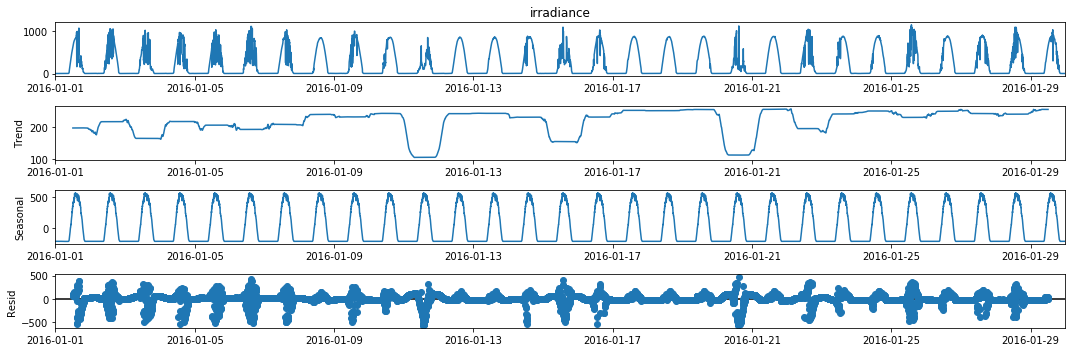

In [41]:
with mpl.rc_context():
    mpl.rc("figure", figsize=(15,5))
    s_decomp_additive = seasonal_decompose(df.loc['2016-01-01 00:00':'2016-01-30 00:00', 'irradiance'], \
                                           model="additive", period=288)
    s_decomp_additive.plot();

### humidity - Seasonality

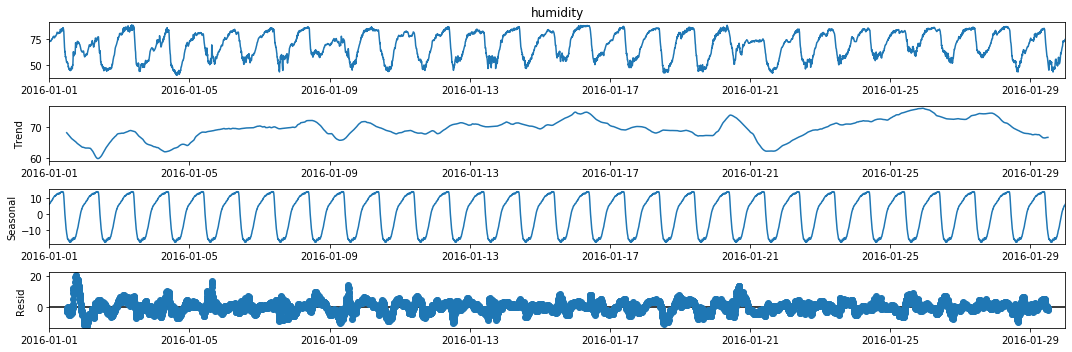

In [42]:
with mpl.rc_context():
    mpl.rc("figure", figsize=(15,5))
    s_decomp_additive = seasonal_decompose(df.loc['2016-01-01 00:00':'2016-01-30 00:00', 'humidity'], \
                                           model="additive", period=288)
    s_decomp_additive.plot();

### temperature - Seasonality

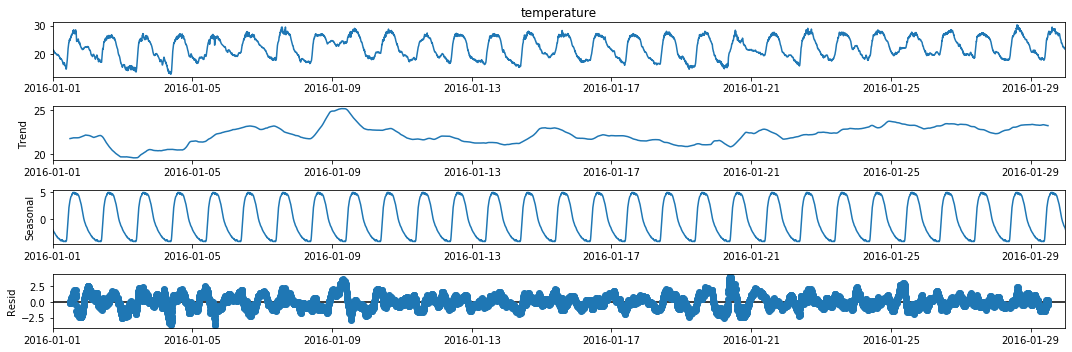

In [43]:
with mpl.rc_context():
    mpl.rc("figure", figsize=(15,5))
    s_decomp_additive = seasonal_decompose(df.loc['2016-01-01 00:00':'2016-01-30 00:00', 'temperature'], \
                                           model="additive", period=288)
    s_decomp_additive.plot();

### energy - Seasonality

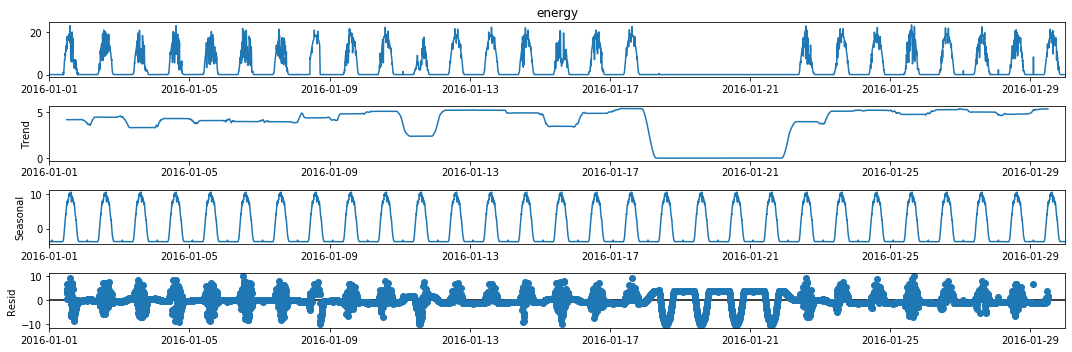

In [44]:
with mpl.rc_context():
    mpl.rc("figure", figsize=(15,5))
    s_decomp_additive = seasonal_decompose(df.loc['2016-01-01 00:00':'2016-01-30 00:00', 'energy'], \
                                           model="additive", period=288)
    s_decomp_additive.plot();

# Auto Correlation Function (ACF)
- All lines are higher than the blue area (i.e., 95% confidence interval); the coefficient is significant, which indicates the time dependence in the data
  - The blue area does not expand much when the number of lags increase
- The plot suggests **the existence of autocorrelation**
- We set `lags=400` and note high correlation around 288 periods, exhibiting **seasonality in 24 hours**, i.e., 24 * 60/5 = 288 periods

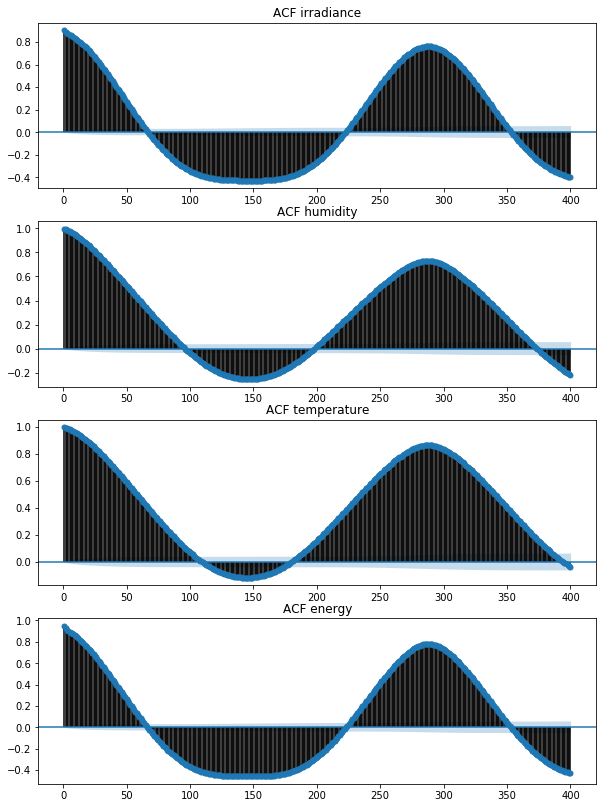

In [45]:
att_list = ['irradiance','humidity','temperature','energy']

fig, axes = plt.subplots(4, 1, figsize=(10,14))

for row, att in zip(axes, att_list):
    sgt.plot_acf(df[att], lags=400, zero=False, title="ACF "+att, ax=row)

# Parial Auto Correlation Function (PACF)
- Plot PACF to determine **direct** relationship between the time series and its lag version
  - PACF cancels out all additional channels a previous period value affects the present one
- Set `method = 'ols'` (Ordinary Least Square) and `lags=40`


- **Notes:** 
  - The first lag of ACF and PACF are identical because there is no other channels for the past value to affect the present value
  - For irradiance and energy, the first 7 lags are significant
  - For humidity, the first 5 lags are significant
  - For temperature, the first 15 lags are significant (except the 2nd lag and 5th lag)

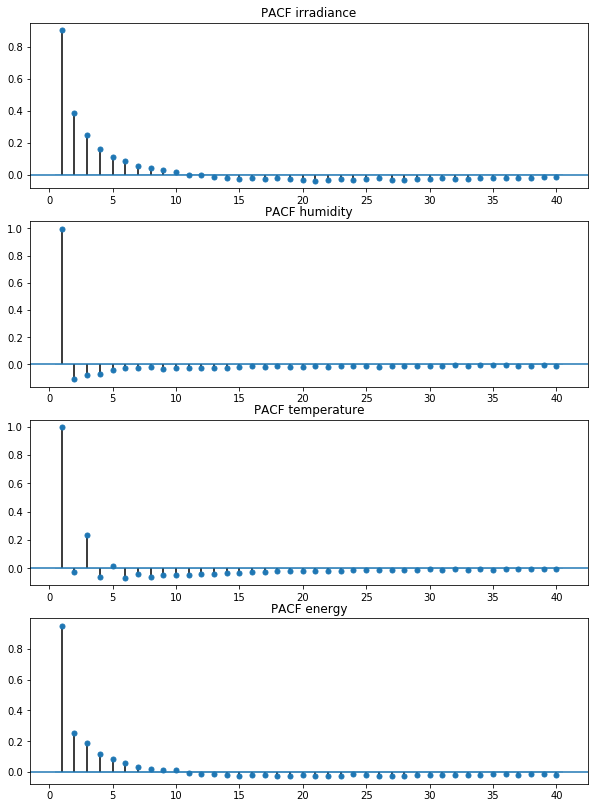

In [212]:
att_list = ['irradiance','humidity','temperature','energy']

fig, axes = plt.subplots(4, 1, figsize=(10,14))

for row, att in zip(axes, att_list):
    sgt.plot_pacf(df[att], lags=40, zero=False, method=('ols'), title="PACF "+att, ax=row)

# CoIntegration
```
Null Hypothesis: No cointegration
Alternative Hypothesis: There is cointegrating relationship
```

- If p-value < critical value, reject Null Hypothesis
- We use 1% critical value in the `find_cointegrated_pairs` function
- irradiance, humidity, temperature, and energy are cointegrated; Their p-values are 0
- This information will be useful when building the time-series model in later section

In [120]:
def find_cointegrated_pairs(data):
    n = data.shape[1]
    pvalue_matrix = np.ones((n, n))
    keys = data.keys()
    pairs = []
    for i in range(n):
        for j in range(i+1, n):
            result = sts.coint(data[keys[i]], data[keys[j]])
            pvalue_matrix[i, j] = result[1]
            if result[1] < 0.01:
                pairs.append((keys[i], keys[j]))
    return pvalue_matrix, pairs 

In [121]:
find_cointegrated_pairs(df)

(array([[1., 0., 0., 0.],
        [1., 1., 0., 0.],
        [1., 1., 1., 0.],
        [1., 1., 1., 1.]]),
 [('irradiance', 'humidity'),
  ('irradiance', 'temperature'),
  ('irradiance', 'energy'),
  ('humidity', 'temperature'),
  ('humidity', 'energy'),
  ('temperature', 'energy')])

# Correlation
- Correlation Matrix reveals that energy is more correlated with irradiance than humidity and temperature
- The impact of irradiance to the prediction of energy will be apparent in SARIMAX model with exogeneous variables in later section

In [122]:
df.corr()

,irradiance,humidity,temperature,energy
irradiance,1.000000,-0.680166,0.648718,0.892197
humidity,-0.680166,1.000000,-0.739020,-0.671793
temperature,0.648718,-0.739020,1.000000,0.634831
energy,0.892197,-0.671793,0.634831,1.000000


# The Quantile-Quantile Plot (QQ Plot) of energy
- Determine if the energy data fits a Normal Distribution
- Since the plot of blue dots deviate from the red line, energy data is **not** Normally Distributed, i.e., we cannot use statistics of Normal Distribution to make forecast

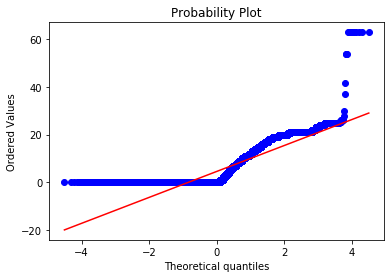

In [123]:
scipy.stats.probplot(df['energy'], plot=pylab)
pylab.show();

# Seasonalilty Model of energy
1. Based on the earlier seasonality analysis, we opt for a seasonal model (`seasonal=True`)
2. Use `auto_arima` with the entire data where `m=288`, and get the Model from `summary()`, for example, SARIMAX(1, 1, 2)x(2, 0, 2, 12)

```
auto_arima(df['energy'], seasonal=True, m=288).summary()
```

3. Split the data into `df_train` and `df_test`
  - Shuffling is **impossible** for time-series data
  - Train data and test data must be **uninterrupted sequences of values**
  - The size of test data is the maximum forecast horizon
  - **30-days forecast horizon**
    - `df_train` is from the beginning to 30-days **prior** to the end
    - `df_test` is the last 30-days of data
    
    
4. Create the SARIMAX model using the result from #2, make predictions, and compare `df_test` and the predictions in a plot

```
model = SARIMAX(df_train['energy'], order=(1,1,2), seasonal_order=(2,0,2,12))
results = model.fit()
results.summary()

start = len(df_train)
end = len(df_train) + len(df_test) - 1
predictions = results.predict(start, end, typ='levels').rename('SARIMA Predictions')

df_test['energy'].plot(legend=True, figsize=(15,5))
predictions.plot(legend=True, figsize=(15,5))
```

# Limitation of Computing Power and `resample()`
- Due to the limitation of computing power of my hardware, running `auto_arima` with `m=288` was never completed
- Possible options:
  1. Use a more powerful server (scale up) to complete the task
  2. **Resample the data from 5-min frequency to 2-hours frequency (24 periods)**.  Then, set `m = 12`, i.e. 288/24 = 12
- Since we do not have access to such a powerful server, we opt for the second option
- We also verify that the seasonality exists where period = 12

### **CAVEAT**
- Since we aggregate the data from 5-min to 2-hours, **the granularity of our prediction will 2 hours**

### Resample the data

In [46]:
df_hour = df.copy()
df_hour = df_hour.resample('2H').mean()
df_hour.shape

(8853, 4)

### Verify the Existence of Seasonality

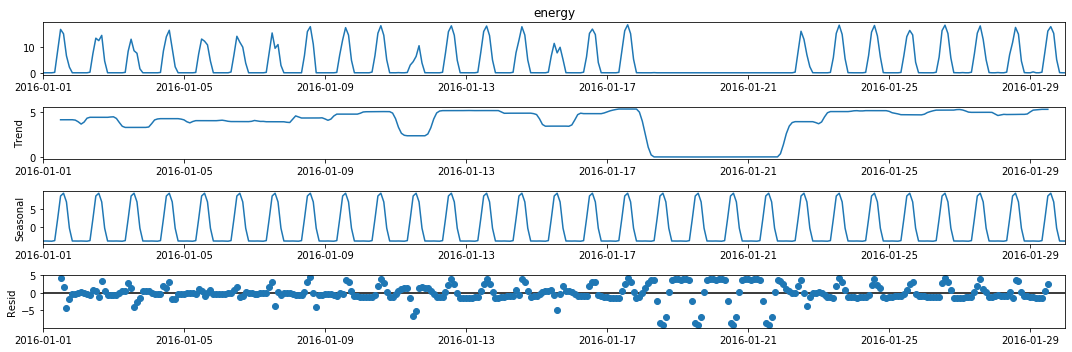

In [47]:
with mpl.rc_context():
    mpl.rc("figure", figsize=(15,5))
    s_decomp_additive = seasonal_decompose(df_hour.loc['2016-01-01 00:00':'2016-01-30 00:00', 'energy'], \
                                           model="additive", period=12)
    s_decomp_additive.plot();

### Run `auto_arima` and Get the Model

In [75]:
auto_arima(df_hour['energy'], seasonal=True, m=12).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                                  y   No. Observations:                 8853
Model:             SARIMAX(1, 1, 2)x(2, 0, 2, 12)   Log Likelihood              -18213.718
Date:                            Sun, 22 Nov 2020   AIC                          36445.436
Time:                                    14:09:07   BIC                          36509.232
Sample:                                         0   HQIC                         36467.162
                                           - 8853                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     4.8e-05   9.38e-05      0.512      0.609      -0.000       0.000
ar.L1          0.4832      0.011     43.017      0.000       0.461       0.505
ma.L1         -0.6837      0.013    -54.694      0.000      -0.708      -0.659
ma.L2         -0.2820      0.011    -25.571      0.000      -0.304      -0.260
ar.S.L12       0.1251      0.029      4.382      0.000       0.069       0.181
ar.S.L24       0.8702      0.028     30.585      0.000       0.814       0.926
ma.S.L12      -0.0232      0.026     -0.906      0.365      -0.074       0.027
ma.S.L24      -0.8264      0.023    -35.549      0.000      -0.872      -0.781
sigma2         3.5667      0.032    110.364      0.000       3.503       3.630
===================================================================================
Ljung-Box (Q):                      320.68   Jarque-Bera (JB):              4968.71
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               1.09   Skew:                            -0.05
Prob(H) (two-sided):                  0.02   Kurtosis:                         6.67
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

### Split Model to `df_train` and `df_test`
- 30 days = 30\*(24/2) = 360 periods

In [48]:
cutoff = len(df_hour)-360
df_train = df_hour.iloc[:cutoff]
df_test = df_hour.iloc[cutoff:]

### Create and Train `SARIMAX` Model
- Use the Model `SARIMAX(1, 1, 2)x(2, 0, 2, 12)` from `summary()` of `auto_arima` above

In [49]:
model = SARIMAX(df_train['energy'], order=(1,1,2), seasonal_order=(2, 0, 2, 12))
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                             energy   No. Observations:                 8493
Model:             SARIMAX(1, 1, 2)x(2, 0, 2, 12)   Log Likelihood              -17359.728
Date:                            Mon, 23 Nov 2020   AIC                          34735.456
Time:                                    09:42:01   BIC                          34791.831
Sample:                                01-01-2016   HQIC                         34754.695
                                     - 12-08-2017                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.5524      0.006     85.219      0.000       0.540       0.565
ma.L1         -0.7733      0.008    -93.051      0.000      -0.790      -0.757
ma.L2         -0.2256      0.008    -27.321      0.000      -0.242      -0.209
ar.S.L12       0.7523      0.043     17.591      0.000       0.669       0.836
ar.S.L24       0.2429      0.043      5.712      0.000       0.160       0.326
ma.S.L12      -0.5454      0.040    -13.487      0.000      -0.625      -0.466
ma.S.L24      -0.3283      0.035     -9.329      0.000      -0.397      -0.259
sigma2         3.4780      0.032    109.571      0.000       3.416       3.540
===================================================================================
Ljung-Box (Q):                      177.90   Jarque-Bera (JB):              5346.22
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               1.08   Skew:                             0.00
Prob(H) (two-sided):                  0.04   Kurtosis:                         6.89
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

### Make Prediction and Compare with the Actual

**Observations**
- The predictions follow seasonality very well
- The peaks of our predictions gradually decrease over time
- The predictions miss the low peaks of test data and the flat values that were imputed for missing values

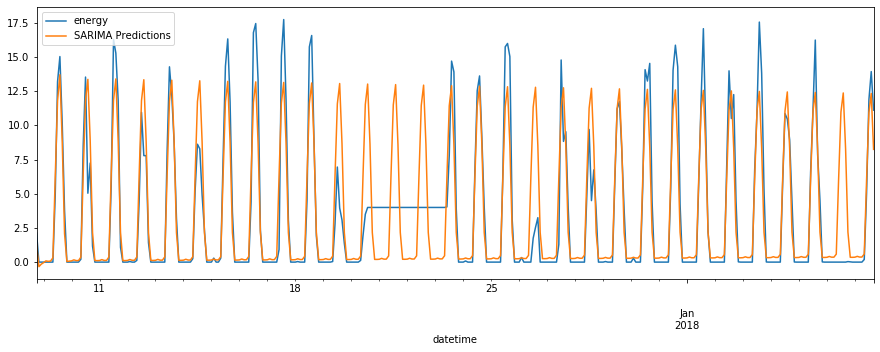

In [50]:
start = len(df_train)
end = len(df_train) + len(df_test) - 1
predictions = results.predict(start, end, typ='levels').rename('SARIMA Predictions')

df_test['energy'].plot(legend=True, figsize=(15,5))
predictions.plot(legend=True, figsize=(15,5));

### Another Plot of Train, Test, and Prediction

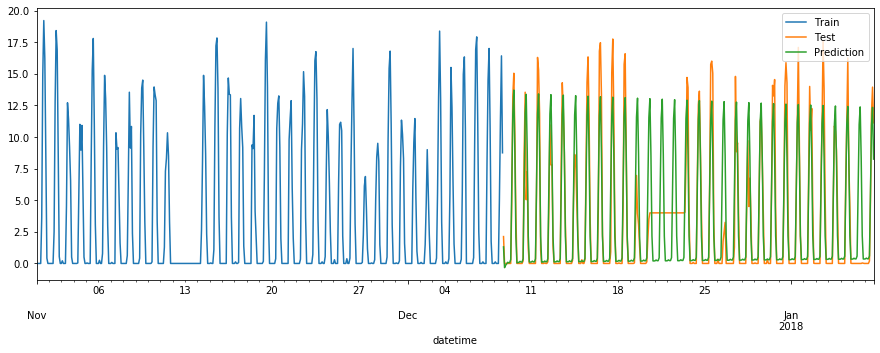

In [51]:
df_train.loc['2017-11-01':,'energy'].plot(legend=True, label='Train', figsize=(15,5))
df_test['energy'].plot(legend=True, label='Test')
predictions.plot(legend=True, label='Prediction');

### Evaluate the Model
- Compute Root-Mean-Squared-Error (RMSE), Mean-Squared-Error (MSE), and Mean-Absolute-Error (MAE)
- Compare RMSE with its mean and standard deviation
- RMS is approx. half of standard deviation, which is not that bad, but it was not very good, either


- In the next section, we will add exogeneous variables to the model to improve the forecasts

In [57]:
rmse_error = rmse(df_test['energy'], predictions)
mse_error = mean_squared_error(df_test['energy'], predictions)
mae_error = mean_absolute_error(df_test['energy'], predictions)

print('rmse error = ', round(rmse_error, 3))
print('mse error = ', round(mse_error, 3))
print('mae error = ', round(mae_error, 3))
print()
print('mean of energy-test = ', round(df_test['energy'].mean(), 3))
print('std of energy-test = ', round(df_test['energy'].std(), 3))

rmse error =  2.689
mse error =  7.232
mae error =  1.582

mean of energy-test =  3.491
std of energy-test =  4.958


# Adding Exogeneous Variable
- We add exogeneous variable(s) when running `auto_arima`, creating SARIMAX model, and making predictions
- It turned out that `auto_arima` yields the same SARIMAX model (`SARIMAX(1,1,2)x(2,0,2,12)`) for different combinations of exogeneous variables
- RMSE, MSE, and MAE of different exogeneous variables are displayed in the table
  - The results are from the experiments in Appendix

|Exogeneous Variable        | RMSE | MSE | MAE |
|:------------|----------:|----------:|------:|
|-    |    2.689      |     7.232     |   1.582  |
|irradiane    |    1.539      |     2.369     |   0.962  |
|humidity|    2.481      |    6.155    |   1.923   |
|temperature    |    2.402     |    5.770    |   1.768 |
|irradiane, humidity    |    1.602     |    2.566    |   1.070 |
|irradiane, temperature    |    8.684     |    75.408    |   7.426 |
|humidity, temperature    |    2.287     |    5.228    |   1.757 |
|irradiane, humidity, temperature    |    **1.448**     |    2.097    |   0.839 |

- The **best model** is SARIMAX(1,1,2)x(2,0,2,12) with exogeneous variables = irradiane, humidity, and temperature
- The plots of Train, Test, and Prediction are shown below
  - The predictions follow seasonality very well
  - The peaks of the predictions can move up-and-down over time
  - The predictions can follow the low peaks of test data and the flat values that were imputed for missing values

**CAVEAT of Using Exogeneous Variable**
- When predicting the **future**, **need to know** the future exogeneous information (or at least have very confident estimations for it based on some other data)

In [69]:
model = SARIMAX(df_train['energy'], \
                exog=df_train[['irradiance','humidity','temperature']], \
                order=(1,1,2), seasonal_order=(2, 0, 2, 12))
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                             energy   No. Observations:                 8493
Model:             SARIMAX(1, 1, 2)x(2, 0, 2, 12)   Log Likelihood              -12650.757
Date:                            Mon, 23 Nov 2020   AIC                          25323.514
Time:                                    10:55:15   BIC                          25401.030
Sample:                                01-01-2016   HQIC                         25349.967
                                     - 12-08-2017                                         
Covariance Type:                              opg                                         
===============================================================================
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
irradiance      0.0174      0.000    164.217      0.000       0.017       0.018
humidity       -0.0176      0.005     -3.791      0.000      -0.027      -0.009
temperature    -0.0322      0.022     -1.447      0.148      -0.076       0.011
ar.L1           0.1760      0.014     12.431      0.000       0.148       0.204
ma.L1          -0.4167      0.015    -27.866      0.000      -0.446      -0.387
ma.L2          -0.3309      0.009    -37.419      0.000      -0.348      -0.314
ar.S.L12        0.2836      0.115      2.468      0.014       0.058       0.509
ar.S.L24        0.6447      0.110      5.844      0.000       0.428       0.861
ma.S.L12       -0.1543      0.116     -1.327      0.185      -0.382       0.074
ma.S.L24       -0.5164      0.095     -5.446      0.000      -0.702      -0.331
sigma2          1.1266      0.007    166.657      0.000       1.113       1.140
===================================================================================
Ljung-Box (Q):                     1433.14   Jarque-Bera (JB):            101834.79
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               1.36   Skew:                            -0.70
Prob(H) (two-sided):                  0.00   Kurtosis:                        19.91
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

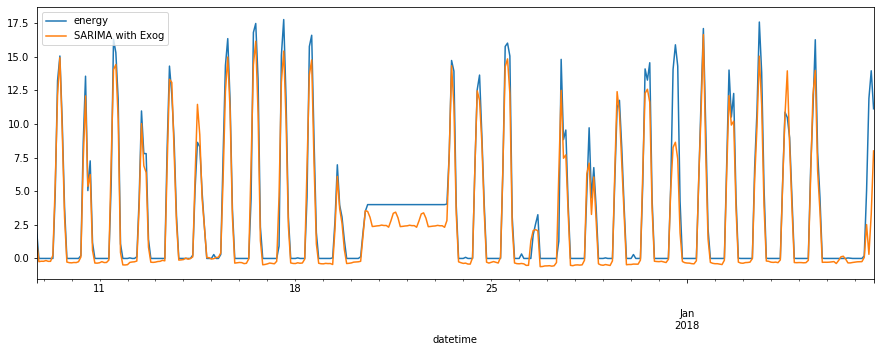

In [71]:
start = len(df_train)
end = len(df_train) + len(df_test) - 1
predictions = results.predict(start, end, \
                              exog=df_test[['irradiance','humidity','temperature']])\
                     .rename('SARIMA with Exog')

df_test['energy'].plot(legend=True, figsize=(15,5))
predictions.plot(legend=True, figsize=(15,5));

### Plot of Train, Test, and Prediction of SARIMAX Model with Exogeneous Variables = irradiance, humidity, and temperature

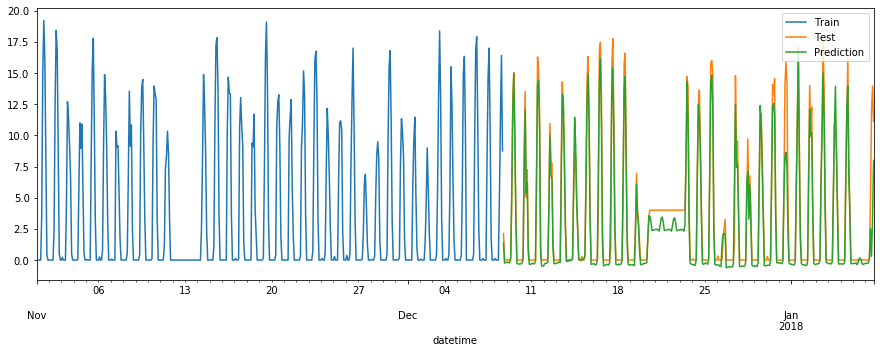

In [72]:
df_train.loc['2017-11-01':,'energy'].plot(legend=True, label='Train', figsize=(15,5))
df_test['energy'].plot(legend=True, label='Test')
predictions.plot(legend=True, label='Prediction');

# Appendix

### Visualize irradiane, humidity, temperature, and energy in the same plot

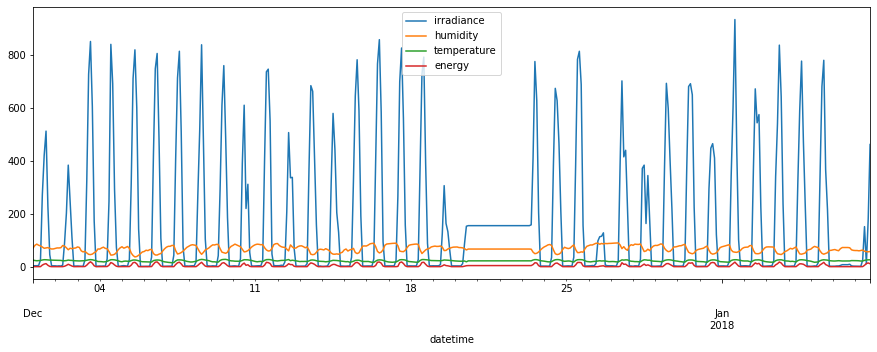

In [146]:
df_hour.loc['2017-12-01':].plot(figsize=(15,5));

### Exog-1 - `exogeneous` = irradiance 

In [150]:
auto_arima(df_hour['energy'], \
           exogeneous=df_hour[['irradiance']], \
           seasonal=True, m=12).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                                  y   No. Observations:                 8853
Model:             SARIMAX(1, 1, 2)x(2, 0, 2, 12)   Log Likelihood              -18213.718
Date:                            Sun, 22 Nov 2020   AIC                          36445.436
Time:                                    17:26:45   BIC                          36509.232
Sample:                                         0   HQIC                         36467.162
                                           - 8853                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     4.8e-05   9.38e-05      0.512      0.609      -0.000       0.000
ar.L1          0.4832      0.011     43.017      0.000       0.461       0.505
ma.L1         -0.6837      0.013    -54.694      0.000      -0.708      -0.659
ma.L2         -0.2820      0.011    -25.571      0.000      -0.304      -0.260
ar.S.L12       0.1251      0.029      4.382      0.000       0.069       0.181
ar.S.L24       0.8702      0.028     30.585      0.000       0.814       0.926
ma.S.L12      -0.0232      0.026     -0.906      0.365      -0.074       0.027
ma.S.L24      -0.8264      0.023    -35.549      0.000      -0.872      -0.781
sigma2         3.5667      0.032    110.364      0.000       3.503       3.630
===================================================================================
Ljung-Box (Q):                      320.68   Jarque-Bera (JB):              4968.71
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               1.09   Skew:                            -0.05
Prob(H) (two-sided):                  0.02   Kurtosis:                         6.67
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [62]:
model = SARIMAX(df_train['energy'], \
                exog=df_train[['irradiance']], \
                order=(1,1,2), seasonal_order=(2, 0, 2, 12))
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                             energy   No. Observations:                 8493
Model:             SARIMAX(1, 1, 2)x(2, 0, 2, 12)   Log Likelihood              -12676.115
Date:                            Mon, 23 Nov 2020   AIC                          25370.231
Time:                                    10:36:45   BIC                          25433.652
Sample:                                01-01-2016   HQIC                         25391.874
                                     - 12-08-2017                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
irradiance     0.0176    8.6e-05    204.425      0.000       0.017       0.018
ar.L1          0.1719      0.015     11.599      0.000       0.143       0.201
ma.L1         -0.4238      0.016    -26.924      0.000      -0.455      -0.393
ma.L2         -0.3278      0.009    -34.797      0.000      -0.346      -0.309
ar.S.L12       0.2699      0.076      3.550      0.000       0.121       0.419
ar.S.L24       0.6649      0.073      9.064      0.000       0.521       0.809
ma.S.L12      -0.1619      0.077     -2.092      0.036      -0.314      -0.010
ma.S.L24      -0.5255      0.064     -8.158      0.000      -0.652      -0.399
sigma2         1.1833      0.007    158.806      0.000       1.169       1.198
===================================================================================
Ljung-Box (Q):                     1602.60   Jarque-Bera (JB):            104070.26
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               1.37   Skew:                            -0.73
Prob(H) (two-sided):                  0.00   Kurtosis:                        20.09
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [63]:
start = len(df_train)
end = len(df_train) + len(df_test) - 1
predictions = results.predict(start, end, \
                              exog=df_test[['irradiance']])\
                     .rename('SARIMA with Exog')

rmse_error = rmse(df_test['energy'], predictions)
mse_error = mean_squared_error(df_test['energy'], predictions)
mae_error = mean_absolute_error(df_test['energy'], predictions)

print('rmse error = ', round(rmse_error, 3))
print('mse error = ', round(mse_error, 3))
print('mae error = ', round(mae_error, 3))

rmse error =  1.539
mse error =  2.369
mae error =  0.962


### Exog-2 - `exogeneous` = irradiance, humidity, and temperature

In [163]:
auto_arima(df_hour['energy'], \
           exogeneous=df_hour[['irradiance','humidity','temperature']], \
           seasonal=True, m=12).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                                  y   No. Observations:                 8853
Model:             SARIMAX(1, 1, 2)x(2, 0, 2, 12)   Log Likelihood              -18213.718
Date:                            Sun, 22 Nov 2020   AIC                          36445.436
Time:                                    17:57:18   BIC                          36509.232
Sample:                                         0   HQIC                         36467.162
                                           - 8853                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     4.8e-05   9.38e-05      0.512      0.609      -0.000       0.000
ar.L1          0.4832      0.011     43.017      0.000       0.461       0.505
ma.L1         -0.6837      0.013    -54.694      0.000      -0.708      -0.659
ma.L2         -0.2820      0.011    -25.571      0.000      -0.304      -0.260
ar.S.L12       0.1251      0.029      4.382      0.000       0.069       0.181
ar.S.L24       0.8702      0.028     30.585      0.000       0.814       0.926
ma.S.L12      -0.0232      0.026     -0.906      0.365      -0.074       0.027
ma.S.L24      -0.8264      0.023    -35.549      0.000      -0.872      -0.781
sigma2         3.5667      0.032    110.364      0.000       3.503       3.630
===================================================================================
Ljung-Box (Q):                      320.68   Jarque-Bera (JB):              4968.71
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               1.09   Skew:                            -0.05
Prob(H) (two-sided):                  0.02   Kurtosis:                         6.67
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [60]:
model = SARIMAX(df_train['energy'], \
                exog=df_train[['irradiance','humidity','temperature']], \
                order=(1,1,2), seasonal_order=(2, 0, 2, 12))
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                             energy   No. Observations:                 8493
Model:             SARIMAX(1, 1, 2)x(2, 0, 2, 12)   Log Likelihood              -12650.757
Date:                            Mon, 23 Nov 2020   AIC                          25323.514
Time:                                    10:34:22   BIC                          25401.030
Sample:                                01-01-2016   HQIC                         25349.967
                                     - 12-08-2017                                         
Covariance Type:                              opg                                         
===============================================================================
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
irradiance      0.0174      0.000    164.217      0.000       0.017       0.018
humidity       -0.0176      0.005     -3.791      0.000      -0.027      -0.009
temperature    -0.0322      0.022     -1.447      0.148      -0.076       0.011
ar.L1           0.1760      0.014     12.431      0.000       0.148       0.204
ma.L1          -0.4167      0.015    -27.866      0.000      -0.446      -0.387
ma.L2          -0.3309      0.009    -37.419      0.000      -0.348      -0.314
ar.S.L12        0.2836      0.115      2.468      0.014       0.058       0.509
ar.S.L24        0.6447      0.110      5.844      0.000       0.428       0.861
ma.S.L12       -0.1543      0.116     -1.327      0.185      -0.382       0.074
ma.S.L24       -0.5164      0.095     -5.446      0.000      -0.702      -0.331
sigma2          1.1266      0.007    166.657      0.000       1.113       1.140
===================================================================================
Ljung-Box (Q):                     1433.14   Jarque-Bera (JB):            101834.79
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               1.36   Skew:                            -0.70
Prob(H) (two-sided):                  0.00   Kurtosis:                        19.91
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [61]:
start = len(df_train)
end = len(df_train) + len(df_test) - 1
predictions = results.predict(start, end, \
                              exog=df_test[['irradiance','humidity','temperature']])\
                     .rename('SARIMA with Exog')

rmse_error = rmse(df_test['energy'], predictions)
mse_error = mean_squared_error(df_test['energy'], predictions)
mae_error = mean_absolute_error(df_test['energy'], predictions)

print('rmse error = ', round(rmse_error, 3))
print('mse error = ', round(mse_error, 3))
print('mae error = ', round(mae_error, 3))

rmse error =  1.448
mse error =  2.097
mae error =  0.839


### Exog-3 - `exogeneous` = irradiance and humidity

In [64]:
model = SARIMAX(df_train['energy'], \
                exog=df_train[['irradiance','humidity']], \
                order=(1,1,2), seasonal_order=(2, 0, 2, 12))
results = model.fit()

start = len(df_train)
end = len(df_train) + len(df_test) - 1
predictions = results.predict(start, end, \
                              exog=df_test[['irradiance','humidity']])\
                     .rename('SARIMA with Exog')

rmse_error = rmse(df_test['energy'], predictions)
mse_error = mean_squared_error(df_test['energy'], predictions)
mae_error = mean_absolute_error(df_test['energy'], predictions)

print('rmse error = ', round(rmse_error, 3))
print('mse error = ', round(mse_error, 3))
print('mae error = ', round(mae_error, 3))

rmse error =  1.602
mse error =  2.566
mae error =  1.07


### Exog-4 - `exogeneous` = irradiance and temperature

In [65]:
model = SARIMAX(df_train['energy'], \
                exog=df_train[['irradiance','temperature']], \
                order=(1,1,2), seasonal_order=(2, 0, 2, 12))
results = model.fit()

start = len(df_train)
end = len(df_train) + len(df_test) - 1
predictions = results.predict(start, end, \
                              exog=df_test[['irradiance','temperature']])\
                     .rename('SARIMA with Exog')

rmse_error = rmse(df_test['energy'], predictions)
mse_error = mean_squared_error(df_test['energy'], predictions)
mae_error = mean_absolute_error(df_test['energy'], predictions)

print('rmse error = ', round(rmse_error, 3))
print('mse error = ', round(mse_error, 3))
print('mae error = ', round(mae_error, 3))

rmse error =  8.684
mse error =  75.408
mae error =  7.426


### Exog-5 - `exogeneous` = humidity and temperature

In [66]:
model = SARIMAX(df_train['energy'], \
                exog=df_train[['humidity','temperature']], \
                order=(1,1,2), seasonal_order=(2, 0, 2, 12))
results = model.fit()

start = len(df_train)
end = len(df_train) + len(df_test) - 1
predictions = results.predict(start, end, \
                              exog=df_test[['humidity','temperature']])\
                     .rename('SARIMA with Exog')

rmse_error = rmse(df_test['energy'], predictions)
mse_error = mean_squared_error(df_test['energy'], predictions)
mae_error = mean_absolute_error(df_test['energy'], predictions)

print('rmse error = ', round(rmse_error, 3))
print('mse error = ', round(mse_error, 3))
print('mae error = ', round(mae_error, 3))

rmse error =  2.287
mse error =  5.228
mae error =  1.757


### Exog-6 - `exogeneous` = humidity

In [67]:
model = SARIMAX(df_train['energy'], \
                exog=df_train[['humidity']], \
                order=(1,1,2), seasonal_order=(2, 0, 2, 12), \
                enforce_stationarity=False)
results = model.fit()

start = len(df_train)
end = len(df_train) + len(df_test) - 1
predictions = results.predict(start, end, \
                              exog=df_test[['humidity']])\
                     .rename('SARIMA with Exog')

rmse_error = rmse(df_test['energy'], predictions)
mse_error = mean_squared_error(df_test['energy'], predictions)
mae_error = mean_absolute_error(df_test['energy'], predictions)

print('rmse error = ', round(rmse_error, 3))
print('mse error = ', round(mse_error, 3))
print('mae error = ', round(mae_error, 3))

rmse error =  2.481
mse error =  6.155
mae error =  1.923


### Exog-7 - `exogeneous` = temperature

In [68]:
model = SARIMAX(df_train['energy'], \
                exog=df_train[['temperature']], \
                order=(1,1,2), seasonal_order=(2, 0, 2, 12))
results = model.fit()

start = len(df_train)
end = len(df_train) + len(df_test) - 1
predictions = results.predict(start, end, \
                              exog=df_test[['temperature']])\
                     .rename('SARIMA with Exog')

rmse_error = rmse(df_test['energy'], predictions)
mse_error = mean_squared_error(df_test['energy'], predictions)
mae_error = mean_absolute_error(df_test['energy'], predictions)

print('rmse error = ', round(rmse_error, 3))
print('mse error = ', round(mse_error, 3))
print('mae error = ', round(mae_error, 3))

rmse error =  2.402
mse error =  5.77
mae error =  1.768
